### ライブラリ

In [130]:
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms

### データの準備

In [121]:
# 前処理
transform = transforms.Compose([
    # 画像をテンソルに変換
    transforms.ToTensor(),
    # 画像のピクセル値を-1~1に正規化
    transforms.Normalize((0.5,), (0.5,))
])

# データセットのダウンロード
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# データローダーの作成
batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

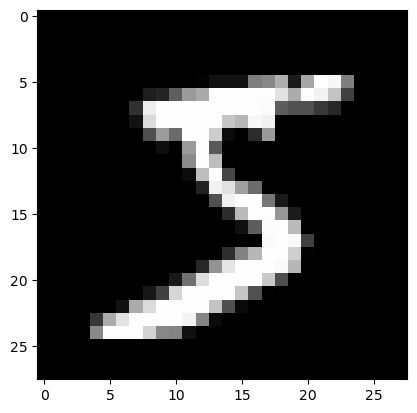

In [122]:
# データセットの確認
image, label = train_dataset[0]
plt.imshow(image[0], cmap='gray')

torch.Size([10, 1, 28, 28])
torch.Size([3, 62, 152])


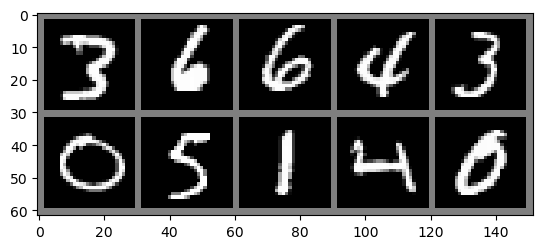

In [123]:
# データローダーの確認
images, labels = next(iter(train_loader))
print(images.shape)                                              # batch_size, channel, height, width
grid_images = torchvision.utils.make_grid(images, nrow=5)
print(grid_images.shape)                                         # channel, height, width
grid_images = grid_images / 2 + 0.5                              # unnormalize
plt.imshow(torch.permute(grid_images, (1, 2, 0)), cmap='gray')   # channel, height, width -> height, width, channel

### モデル定義

In [124]:
# アーキテクチャの定義
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten()                 # [batch_size, channel, height, width] -> [batch_size, channel * height * width]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

# モデルのインスタンス化
model = MLP(28*28, 30, 10)

# モデルの確認
print(model.parameters)

<bound method Module.parameters of MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)>


In [125]:
# optimizerの定義
leraning_rate = 0.01
opt = optim.SGD(model.parameters(), lr=leraning_rate)

In [131]:
# learning rate schedulerの定義
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

### 学習

In [126]:
# ログの保存
train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
no_improve = 0

# parameter
num_epochs = 30
early_stopping = 3


# 学習
for epoch in range(num_epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0

    for train_batch, data in enumerate(train_loader):

        # データの取り出し
        X, y = data
        # 勾配の初期化
        opt.zero_grad()
        # 順伝播
        preds = model(X)
        # 損失の計算
        loss = F.cross_entropy(preds, y)
        running_loss += loss.item()
        # 逆伝播
        loss.backward()
        # パラメータの更新
        opt.step()
    
    # validation
    with torch.no_grad():
        for val_batch, data in enumerate(val_loader):
            X_val, y_val = data
            preds_val = model(X_val)
            val_loss = F.cross_entropy(preds_val, y_val)
            running_val_loss += val_loss.item()
            val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val).item() / y_val.shape[0]
            running_val_acc += val_accuracy

    # epochごとの損失の保存
    train_losses.append(running_loss / (train_batch + 1))
    val_losses.append(running_val_loss / (val_batch + 1))
    val_accuracies.append(running_val_acc / (val_batch + 1))

    # 損失の表示
    print(f'Epoch: {epoch}, train Loss: {train_losses[-1]}, val Loss: {val_losses[-1]}, val Accuracy: {val_accuracies[-1]}')

    # early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        no_improve = 0
    else:
        no_improve += 1
        if no_improve > early_stopping:
            print('early stopping')
            break
    
    # learning rateの更新
    scheduler.step()

Epoch: 0, train Loss: 0.4172641909373924, val Loss: 0.2574998234140221, val Accuracy: 0.9247999999999952
Epoch: 1, train Loss: 0.23546656835118, val Loss: 0.19214284394029527, val Accuracy: 0.9418999999999953
Epoch: 2, train Loss: 0.18772043152529902, val Loss: 0.17141029117954895, val Accuracy: 0.9493999999999956
Epoch: 3, train Loss: 0.1613014594920872, val Loss: 0.15858115464629371, val Accuracy: 0.9537999999999957
Epoch: 4, train Loss: 0.1427945498454986, val Loss: 0.14164594814096926, val Accuracy: 0.956499999999996
Epoch: 5, train Loss: 0.13122848511823396, val Loss: 0.13069493334391155, val Accuracy: 0.9600999999999963
Epoch: 6, train Loss: 0.12158697176404287, val Loss: 0.12610538819406064, val Accuracy: 0.9599999999999965
Epoch: 7, train Loss: 0.11315414108614884, val Loss: 0.11768992697791691, val Accuracy: 0.9639999999999965
Epoch: 8, train Loss: 0.10720298062869309, val Loss: 0.1164480647387827, val Accuracy: 0.9644999999999967
Epoch: 9, train Loss: 0.1010376321098156, val 

### 損失の可視化

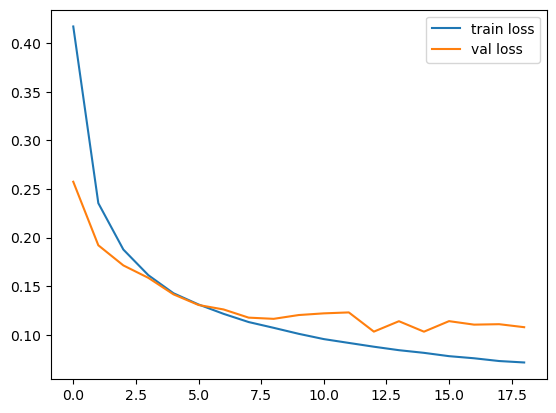

In [127]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()

### モデルの保存

In [128]:
# モデルオブジェクトの保存
torch.save(model, 'sample_model.pth')
# モデルのロード
loaded_model = torch.load('sample_model.pth')

In [129]:
# モデルのパラメータのみの保存(推奨)
params = model.state_dict()
torch.save(params, 'sample_model_param.pth')
# パラメータのロード
another_model = MLP(28*28, 30, 10)
another_model.load_state_dict(torch.load('sample_model_param.pth'))
# 確認
print(model.l1.weight)
print(another_model.l1.weight)

Parameter containing:
tensor([[-3.3253e-02, -6.8095e-03, -3.1900e-02,  ..., -3.0858e-02,
         -2.3968e-02, -1.6548e-02],
        [-1.1598e-02, -2.6237e-02,  1.9219e-02,  ...,  2.0764e-02,
         -3.8758e-02, -3.9687e-02],
        [-1.4179e-03,  1.4116e-02,  2.5029e-02,  ..., -7.0399e-03,
          2.3769e-02,  1.4482e-03],
        ...,
        [-2.4439e-02,  2.0459e-04, -8.7206e-04,  ...,  1.5193e-02,
          3.4505e-05, -2.3460e-02],
        [ 2.2007e-02, -2.9599e-02,  1.5301e-02,  ...,  1.1442e-02,
          2.6734e-02,  1.7677e-02],
        [ 2.9170e-02, -3.0232e-03, -1.5634e-02,  ...,  2.3946e-02,
          2.5026e-02, -8.4594e-03]], requires_grad=True)
Parameter containing:
tensor([[-3.3253e-02, -6.8095e-03, -3.1900e-02,  ..., -3.0858e-02,
         -2.3968e-02, -1.6548e-02],
        [-1.1598e-02, -2.6237e-02,  1.9219e-02,  ...,  2.0764e-02,
         -3.8758e-02, -3.9687e-02],
        [-1.4179e-03,  1.4116e-02,  2.5029e-02,  ..., -7.0399e-03,
          2.3769e-02,  1.4482e-